In [162]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from make_map import make_map

from file_util import load_matlab_data
# from channel_overlap import channel_overlap
from plot import plot_discharge
from metrics import *
from stratigraphy import sedimentograph
from spatial_dist import *
from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString
import rasterio
from rasterio.features import shapes

from osgeo import ogr, gdal, osr
from shapely.ops import transform, polygonize_full

import cPickle as pickle
import fiona
import itertools



def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    
    output_raster = gdal.GetDriverByName('GTiff').Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    #writing output raster
    output_raster.GetRasterBand(1).WriteArray( array ) 
    output_raster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(32645)
    output_raster.SetProjection(srs.ExportToWkt())
    output_raster.FlushCache()

def latlong_to_index(pt, xmin, xmax, ymin, ymax, array_size):
    
    newx = int(array_size[1] * (pt[0] - xmin) / (xmax - xmin))
    newy = int(array_size[0] - array_size[0] * (pt[1] - ymin) / (ymax - ymin))
    
    return (newx, newy)



def create_shapefile_from_shapely_multi(features, filename,
                                        fields = {}, field_type = {},
                                        buffer_width = 0, spatial_ref = 32645):


    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(filename)

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(spatial_ref)

    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)

    # Add attributes
#     fieldDefn = ogr.FieldDefn('id', ogr.OFTReal)
#     layer.CreateField(fieldDefn)

    for f in fields.keys():
        fieldDefn = ogr.FieldDefn(f, field_type[f])
        layer.CreateField(fieldDefn)

    defn = layer.GetLayerDefn()


    for i in range(len(features)):

        poly = features[i].buffer(buffer_width)

        # Create a new feature (attribute and geometry)
        feat = ogr.Feature(defn)
        
#         feat.SetField('id', i)

        for f in fields.keys():
            feat.SetField(f, fields[f][i])

        # Make a geometry from Shapely object
        geom = ogr.CreateGeometryFromWkb(poly.wkb)
        feat.SetGeometry(geom)

        layer.CreateFeature(feat)
        feat = geom = None  # destroy these


    # Save and close everything
    ds = layer = feat = geom = None

    
    
    
def create_tiff_from_shapefile(InputVector, OutputImage, RefImage):

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels

    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterise
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage,
                                                     Image.RasterXSize,
                                                     Image.RasterYSize,
                                                     1,
                                                     datatype,
                                                     options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None
    

def read_tiff_as_array(filename):
    
    src_ds = gdal.Open(filename)

    try:
        srcband = src_ds.GetRasterBand(1)
    except RuntimeError, e:
        # for example, try GetRasterBand(10)
        print 'Band ( %i ) not found' % band_num
        print e
        sys.exit(1)

    network_raster = srcband.ReadAsArray()
    
    return network_raster

In [2]:
def get_value_of_raster_within_polygons(raster, polygons, r_xmin, r_xmax, r_ymin, r_ymax, min_valid_label = None):
    
    poly_points_utm = [i.representative_point().coords[0] for i in polygons]
    poly_points_index = [latlong_to_index(i, r_xmin, r_xmax, r_ymin, r_ymax, raster.shape) for i in poly_points_utm]
    
    poly_points_value = [raster[i[::-1]] for i in poly_points_index]
    
    step = 10

    while (min_valid_label is not None) & (step < 25):

        bad_pts = np.where(np.array(poly_points_value) < min_valid_label)[0]

        if len(bad_pts) > 0:
            
            for i in bad_pts:

                pts = RegularGridSampling(polygons[i], step = step)
                pts_utm = [p.coords[0] for p in pts]
                pts_index = [latlong_to_index(p, r_xmin, r_xmax, r_ymin, r_ymax, raster.shape) for p in pts_utm]
                pts_value = [raster[p[::-1]] for p in pts_index]
                good_pts = np.where(np.array(pts_value) >= min_valid_label)[0]

                if len(good_pts) > 0:
                    poly_points_value[i] = pts_value[good_pts[0]]
                    poly_points_index[i] = pts_index[good_pts[0]]
                    
            step += 5
        else:
            step = 100
            
    bad_pts = np.where(np.array(poly_points_value) < min_valid_label)[0]
    
    return poly_points_value, poly_points_index, bad_pts
    

def RegularGridSampling(polygon, x_interval = None, y_interval = None, step = None):
    """
    Perform sampling by substituting the polygon with a regular grid of
    sample points within it. The distance between the sample points is
    given by x_interval and y_interval.
    """
    samples = []
    
    if step is None:
        step = 10
    
    if x_interval is None:
        x_interval = (polygon.bounds[2] - polygon.bounds[0]) / step
        
    if y_interval is None:   
        y_interval = (polygon.bounds[3] - polygon.bounds[1]) / step
    
    ll = polygon.bounds[:2]
    ur = polygon.bounds[2:]
    low_x = int(ll[0]) / x_interval * x_interval
    upp_x = int(ur[0]) / x_interval * x_interval + x_interval
    low_y = int(ll[1]) / y_interval * y_interval
    upp_y = int(ur[1]) / y_interval * y_interval + y_interval

    for x in np.arange(low_x, upp_x, x_interval):
        for y in np.arange(low_y, upp_y, y_interval):
            p = Point(x, y)
            if p.within(polygon):
                samples.append(p)
                
    
                
    return MultiPoint(samples)


def SaveRaster(array, filename, r_xmin, r_ymin, res, downsampling = 1):

    rasterOrigin = (r_xmin, r_ymin)
    pixelWidth = res * downsampling
    pixelHeight = res * downsampling

    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(filename,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster
    
    
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360), from vertical'''
    
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    az = np.degrees(angle) if angle > 0 else np.degrees(angle) + 360
    
    return az

In [3]:
# statistics for distributions

def mean_(val, freq):
    return np.average(val, weights = freq)

def median_(val, freq):
    order = np.argsort(val)
    cdf = np.cumsum(freq[order])
    return val[order][np.searchsorted(cdf, cdf[-1] // 2)]

def mode_(val, freq): #in the strictest sense, assuming unique mode
    return val[np.argmax(freq)]

def var_(val, freq):
    avg = mean_(val, freq)
    dev = freq * (val - avg) ** 2
    return dev.sum() / (freq.sum() - 1)

def std_(val, freq):
    return np.sqrt(var_(val, freq))

In [17]:
def Polygon_axes(polygon):
    '''
    Calculates major and minor axes, and major axis azimuth, for a Shapely polygon
    '''

    rect = polygon.minimum_rotated_rectangle.exterior

    len1 = LineString(rect.coords[0:2]).length
    len2 = LineString(rect.coords[1:3]).length

    if len1 > len2:
        orientation = azimuth(Point(rect.coords[0]), Point(rect.coords[1]))
    else:
        orientation = azimuth(Point(rect.coords[1]), Point(rect.coords[2]))
        
    if orientation > 180:
        orientation = orientation - 180

    axminor, axmajor = np.sort([len1, len2])

    return axminor, axmajor, orientation

In [49]:
def get_CDF(data):
    # calculate the Cumulative Distribution Function (CDF)

    data_sorted = np.flipud(np.sort(data))
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    return [data_sorted, p]



# data_sorted, p = get_CDF(island_prop_array[:,24])

# plt.figure()
# plt.loglog(data_sorted, p)

In [4]:
src_ds = gdal.Open('ganges_metrics/gangeschan.tif')

try:
    srcband = src_ds.GetRasterBand(1)
except RuntimeError, e:
    # for example, try GetRasterBand(10)
    print 'Band ( %i ) not found' % band_num
    print e
    sys.exit(1)
    
raster = srcband.ReadAsArray()

ulx, xres, xskew, uly, yskew, yres  = src_ds.GetGeoTransform()
lrx = ulx + (src_ds.RasterXSize * xres)
lry = uly + (src_ds.RasterYSize * yres)

r_xmax, r_xmin, r_ymax, r_ymin = lrx, ulx, uly, lry
r_xres, r_yres = xres, yres

In [5]:
downsample = 1

ganges_map = raster[::downsample,::downsample]
pixel_size = xres * downsample

ganges_map[ganges_map <= 1] = 0
ganges_map[ganges_map > 1] = 1

topo = ganges_map.copy().astype('float')
topo[topo == 1] = 0.5
topo[topo == 0] = -5

vel = ganges_map.copy()
vel = (vel == 0) * 1


mapfile = {}

mapfile['wetmap'] = vel
mapfile['landmap'] = (topo > 0) * 1.

islandmap0 = np.minimum(1, mapfile['wetmap'] + (1 - mapfile['landmap']))
mapfile['islandmap'] = islandmap0 == 0

In [6]:
# create initial islandmap from image

islandmap, = island_properties(mapfile, smooth = True, properties = False)

In [7]:
# get islands from network shapefile

c = fiona.open('ganges_metrics/network.shp')

network_lines = MultiLineString([shape(pol['geometry']) for pol in c])
network_widths = [line['properties']['Width'] for line in c]
network_azimuths = [azimuth(Point(l.coords[0]),Point(l.coords[-1])) for l in network_lines]

result, dangles, cuts, invalids = polygonize_full(network_lines)
islands = MultiPolygon([i for i in result if i.area > r_xres * r_xres * 10])

c = None
# islands = MultiPolygon(result)


# find islands with interior polygons
# first number is index of island with interior polygons
# second number is index of interior island

get_contained_islands = False

if get_contained_islands:
    i
    contained_islands = []

    for i in range(len(islands)):

        # if island has an inner ring
        if not islands[i].exterior.equals(islands[i].boundary):

            # check all other islands
            for j in range(len(islands)):
                if i != j:

                    # check if one is inside the other
                    inside = islands[j].within(Polygon(islands[i].exterior))

                    if inside:
                        contained_islands.append([i,j])

    pickle.dump(contained_islands, open( 'ganges_metrics/contained_islands' + '.p', "wb" ) )
    
else:
    
    contained_islands = pickle.load( open( 'ganges_metrics/contained_islands.p', "rb" ) )


bad_islands = set([i[1] for i in contained_islands])
holey_islands = set([i[0] for i in contained_islands])

new_islands = [Polygon(islands[i].exterior) if i in holey_islands else islands[i] for i in range(len(islands))]
new_islands = [new_islands[i] for i in range(len(new_islands)) if i not in bad_islands]

islands = MultiPolygon(new_islands)



In [8]:
make_subsets = False

if make_subsets:

    xmid = r_xmin + (r_xmax - r_xmin)/2.
    x14 = r_xmin + (r_xmax - r_xmin)/4.
    x34 = r_xmin + 3*(r_xmax - r_xmin)/4.
    ymid = r_ymin + (r_ymax - r_ymin)/2.
    y14 = r_ymin + (r_ymax - r_ymin)/4.

    full_poly = Polygon([(r_xmin, r_ymin), (r_xmax, r_ymin), (r_xmax, r_ymax), (r_xmin, r_ymax)])
    subset_poly = Polygon([(xmid, r_ymin), (r_xmax, r_ymin), (r_xmax, y14), (xmid, y14)])

    sub_network = [n for n,l in enumerate(network_lines) if l.within(subset_poly)]
    sub_islands = [n for n,l in enumerate(islands) if l.within(subset_poly)]
    sub_cuts = [n for n,l in enumerate(dangles) if l.within(subset_poly)]

In [9]:
get_bounding_channels = False

if get_bounding_channels:

    # midpoints of network lines, with buffers
    midpts = [l.interpolate(0.5, normalized=True).buffer(5) for l in network_lines]

    bounds = []
    interior_channels = []

    # check if line midpoints intersect the island outlines
    #(to identify which lines make up each island)
    for polygon in islands:
    
        touch = [i for i,l in enumerate(midpts) if polygon.exterior.intersects(l)]
        bounds.append(touch)
        
        touch = [i for i,l in enumerate(midpts) if polygon.contains(l)]
        interior_channels.append(touch)

    pickle.dump(bounds, open( 'ganges_metrics/island_boundary_channels' + '.p', "wb" ) )
    pickle.dump(interior_channels, open( 'ganges_metrics/island_interior_channels' + '.p', "wb" ) )

else:    
    bounds = pickle.load( open( 'ganges_metrics/island_boundary_channels.p', "rb" ) )
    interior_channels = pickle.load( open( 'ganges_metrics/island_interior_channels.p', "rb" ) )
    
flat_bounds = np.unique([item for sublist in bounds for item in sublist])

In [10]:
# create shapefile and raster of the network islands

create_island_GIS = False

if create_island_GIS:

    channel_bounds = [network_lines[i] for i in flat_bounds]

    create_shapefile_from_shapely_multi(MultiLineString(channel_bounds),
                                        'ganges_metrics/islands_polygons.shp',
                                        buffer_width = pixel_size/2.)


    create_tiff_from_shapefile('ganges_metrics/islands_polygons.shp',
                               'ganges_metrics/islands_polygons.tif',
                               'ganges_metrics/gangeschan.tif')

In [11]:
# Etch the network islands onto the islandmap found from the image
# to highlight channels that are not seen as continuous in the image
#
# Then run island_properties again and get island properties

get_new_island_properties = False
pickle_island_properties = False

if get_new_island_properties:
    network_raster = read_tiff_as_array('ganges_metrics/islands_polygons.tif')

    mapfile['islandmap'] = (islandmap > 0) & (network_raster == 0)
    islandmap1, island_props0, ecmf, EdgeDistMap, histogram = island_properties(mapfile, smooth = False, properties = True)

    # remove invalid labels (set with min_valid_label) and
    # then enough of the smallest island labels to have
    # the same number as islands from the network

    min_valid_label = 3

    num_id_islands = len(island_props0['label'])
    expected_num_islands = len(islands)

    diff_number = num_id_islands - expected_num_islands - min_valid_label



    # label must be less than min_valid_label
    # then remove the smallest diff_number islands

    area_sort = np.argsort(island_props0['area'])

    flag = False
    dn = 0

    while (not flag) & (dn <= min_valid_label):

        dn += 1
        small_island_id = [i for i in area_sort[:diff_number+dn] if island_props0['label'][i] >= min_valid_label]

        flag = len(small_island_id) == diff_number + dn


    keep_props_id = [i for i in area_sort[diff_number+dn:] if island_props0['label'][i] >= min_valid_label]

    island_props = {}

    for f,v in island_props0.items():
        island_props[f] = np.array(island_props0[f])[keep_props_id]
        
        
    if pickle_island_properties:
    
        pickle.dump(island_props, open( 'ganges_metrics/metrics_results/island_props' + '.p', "wb" ) )

        pickle.dump(ecmf, open( 'ganges_metrics/metrics_results/ecmf' + '.p', "wb" ) )
        pickle.dump(EdgeDistMap, open( 'ganges_metrics/metrics_results/EdgeDistMap' + '.p', "wb" ) )
        pickle.dump(histogram, open( 'ganges_metrics/metrics_results/histogram' + '.p', "wb" ) )


        SaveRaster(islandmap1, 'ganges_metrics/metrics_results/island_map_HD.tif', r_xmin, r_ymin, r_xres, downsample)
        
else:
    
    island_props = pickle.load( open( 'ganges_metrics/metrics_results/island_props.p', "rb" ) )
#     islandmap1 = pickle.load( open( 'ganges_metrics/metrics_results/islandmap1.p', "rb" ) )
    islandmap1 = read_tiff_as_array('ganges_metrics/metrics_results/island_map_HD.tif')

In [12]:
get_poly_label = False

# poly_label is an array of the size of islands with the label from islandmap1
#(and therefore the connection to island_props)

if get_poly_label:

    poly_label, poly_index, bad_pts = get_value_of_raster_within_polygons(islandmap1,
                                                                          islands,
                                                                          r_xmin, r_xmax,
                                                                          r_ymin, r_ymax,
                                                                          min_valid_label=3)
    poly_label = np.array(poly_label)

    pickle.dump([poly_label, poly_index], open( 'ganges_metrics/poly_label' + '.p', "wb" ) )
    
else:
    
    poly_label, poly_index = pickle.load( open( 'ganges_metrics/poly_label.p', "rb" ) )

In [13]:
get_channel_props = False

if get_channel_props:

    # associate channel properties to islands

    network_avg_widths = np.zeros((len(islands),))
    network_max_widths = np.zeros((len(islands),))

    for n in range(len(islands)):

        i = islands[n]

        # channels added in open water to close island polygons have width 9999
        channels = [network_lines[b] for b in bounds[n] if network_widths[b] != 9999]
        widths = [network_widths[b] for b in bounds[n] if network_widths[b] != 9999]
        lengths = [c.length for c in channels]


        tot_length = sum(lengths)
        avg_width = sum([widths[b] * lengths[b] for b in range(len(widths))]) / tot_length
        max_width = max(widths)


        network_avg_widths[n] = avg_width
        network_max_widths[n] = max_width
        
    pickle.dump([network_avg_widths, network_max_widths], open( 'ganges_metrics/channel_widths' + '.p', "wb" ) )
    
else:
    
    network_avg_widths, network_max_widths = pickle.load( open( 'ganges_metrics/channel_widths.p', "rb" ) )

In [14]:
# channel angle
calculate_bound_channel_stats = False

if calculate_bound_channel_stats:


    angle_stats = []

    for b in bounds:

        val = []
        freq = []

        lines = [network_lines[l] for l in b]
        lengths = [l.length/2 for l in lines]

        if len(lines)>1:

            for l1,l2 in itertools.combinations(range(len(lines)),2):

                if lines[l1].touches(lines[l2]):

                    node = lines[l1].intersection(lines[l2])

                    if node.type is 'MultiPoint':
                        node = node[0]

                    buffer_l = np.min([lines[l1].length * 0.6, lines[l2].length * 0.6, 500])

                    intersect0 = lines[l1].intersection(node.buffer(buffer_l).exterior)
                    if intersect0.type is 'MultiPoint':
                        intersect0 = intersect0[0]

                    az0 = azimuth(node, intersect0)

                    intersect1 = lines[l2].intersection(node.buffer(buffer_l).exterior)
                    if intersect1.type is 'MultiPoint':
                        intersect1 = intersect1[0]

                    az1 = azimuth(node, intersect1)

                    az = np.abs(az0 - az1)
                    diff_az = az if az<180 else az-180

                    frac_length = (lengths[l1] + lengths[l2])

                    freq.append(frac_length)
                    val.append(diff_az)

            val = np.array(val)
            freq = np.array(freq)

            angle_stats.append([mean_(val, freq), median_(val, freq),
                                mode_(val, freq), var_(val, freq), std_(val, freq)])

        else:

            angle_stats.append([0,0,0,0,0])


    pickle.dump(angle_stats, open( 'ganges_metrics/metrics_results/bound_channel_angle_stats' + '.p', "wb" ))
    
else:

    angle_stats = pickle.load( open( 'ganges_metrics/metrics_results/bound_channel_angle_stats.p', "rb" ) )

angle_stats = np.array(angle_stats)

In [57]:
calc_sinuosity = True

if calc_sinuosity:

    sinuosity_all = []

    for c_dist in [500, 1000, 1500]:

        sinuosity = []

        for i in islands:

            lines = i.exterior

            if lines.length > c_dist*4:

                coords = np.zeros((int(lines.length / c_dist)+1, 2))

                for n,d in enumerate(np.arange(0, lines.length+1, c_dist)):  
                    coords[n,:] = lines.interpolate(d).coords[0]

                diff = np.diff(coords, axis=0)
                l_dist = np.sqrt(diff[:,0]**2 + diff[:,1]**2)

                sinuosity.append(np.mean(c_dist / l_dist))

            else:

                sinuosity.append(1)


        sinuosity_all.append(sinuosity)

    sinuosity_all = np.array(sinuosity_all)
        
    pickle.dump(sinuosity_all, open( 'ganges_metrics/metrics_results/bound_channel_sinuosity_vals' + '.p', "wb" ))

else:
    
    sinuosity_all = pickle.load( open( 'ganges_metrics/metrics_results/bound_channel_sinuosity_vals.p', "rb" ) )

    

In [156]:
c = fiona.open('ganges_metrics/islands.shp') # other metrics

shp_islands = [shape(i['geometry']) for i in c if i['properties']['DN'] > 2]
shp_islands_label = np.array([i['properties']['DN'] for i in c if i['properties']['DN'] > 2])

c = None

In [157]:
re_order_shp = np.zeros_like(island_props['label'])

for n,i in enumerate(poly_label):
    
    loc_shp = np.where(shp_islands_label == i)[0][0]
    re_order_shp[n] = loc_shp

shp_islands = [shp_islands[i] for i in re_order_shp]
shp_islands_label = shp_islands_label[re_order_shp]

smooth_islands = []

for n in range(len(shp_islands)):
    
    s = shp_islands[n]

    counter = 0
    while not s.is_valid and (counter < 10):
        s = Polygon(s.exterior.simplify(50))
        counter += 1
        
    smooth_islands.append(s)

In [160]:
get_poly_metrics = False

if get_poly_metrics:

#     maximum_inscribed_circle_radius = np.zeros_like(perimeter)

#     for n,label in enumerate(shp_islands_label):

#         isl = shp_islands[n]
#         maximum_inscribed_circle_radius[n] = max([isl.boundary.distance(p) for p in RegularGridSampling(isl, step = 20)])



    perimeter = np.array([i.boundary.length for i in smooth_islands])
    wetted_perimeter = np.array([i.boundary.length for i in shp_islands])    
    area = np.array([i.area for i in shp_islands])
    perimeter_convex_hull = np.array([i.convex_hull.exterior.length for i in shp_islands])
    area_convex_hull = np.array([i.convex_hull.area for i in shp_islands])

    a = np.array(map(Polygon_axes, shp_islands))
    minor_axis = a[:,0]
    major_axis = a[:,1]
    poly_orientation = a[:,2]
    aspect_ratio = major_axis / minor_axis

    circularity = 4 * np.pi * area / perimeter**2
    equivalent_area_diameter = np.sqrt((4 / np.pi) * area)
    perimeter_equivalent_diameter = area / np.pi
    solidity = area / area_convex_hull
    concavity = area_convex_hull - area
    convexity = perimeter_convex_hull / perimeter
    dry_shape_factor = perimeter / np.sqrt(area)
    wet_shape_factor = wetted_perimeter / np.sqrt(area)

    poly_metrics = {'p_area': area,
                    'p_perim': perimeter,
                    'p_wetperim': wetted_perimeter,
                    'p_ch_area': area_convex_hull,
                    'p_ch_perim': perimeter_convex_hull,
#                     'p_max_rad': maximum_inscribed_circle_radius,
                    'p_major_ax': major_axis,
                    'p_minor_ax': minor_axis,
                    'p_asp_rat': aspect_ratio,
                    'p_orient': poly_orientation,
                    'p_circ': circularity,
                    'p_eq_a_dia': equivalent_area_diameter,
                    'p_p_eq_dia': perimeter_equivalent_diameter,
                    'p_solidity': solidity,
                    'p_concav': concavity,
                    'p_convex': convexity,
                    'p_d_shapef': dry_shape_factor,
                    'p_w_shapef': wet_shape_factor,
                    'p_label': shp_islands_label}

    pickle.dump(poly_metrics, open( 'ganges_metrics/metrics_results/island_shp_metrics' + '.p', "wb" ) )

else:

    poly_metrics = pickle.load( open( 'ganges_metrics/metrics_results/island_shp_metrics.p', "rb" ) )

In [1000]:
# find angle that outflow channel makes with boundary

find_outflow_angles = True

if find_outflow_angles:

    outflow_angles = []
    num_outflow = np.zeros((len(islands),))

    for n in range(len(islands)):

        lines = [i for i in interior_channels[n]]

        # interior channels that touch the boundary
        outflow = []

        for l in lines:
            if islands[n].exterior.touches(network_lines[l]):
                outflow.append(l)


        angle = []
#         num_outflow[n] = len(outflow)

        num_out = 0

        for l in outflow:

            inside_line = smooth_islands[n].intersection(network_lines[l])
            node = smooth_islands[n].boundary.intersection(network_lines[l])

            if node.type is 'GeometryCollection':
                node = shp_islands[n].boundary.intersection(network_lines[l])

            if inside_line.type is 'LineString':

                if node.type is 'LineString':
                    node = MultiPoint(node.coords)

                if node.type is 'MultiPoint':

                    dists = np.array([nn.distance(smooth_islands[n].exterior) for nn in node])
                    loc = np.where(dists == dists.min())[0][0]
                    node = node[loc]

                buffer_l = np.min([inside_line.simplify(100).length * 0.8,
                                   250])

                try:
                    intersect0 = inside_line.intersection(node.buffer(buffer_l).exterior)
                    if intersect0.type is 'MultiPoint':
                        intersect0 = intersect0[0]    
                    az0 = azimuth(node, intersect0)

                except:
                    intersect0 = Point(inside_line.coords[-1])

                    if intersect0.intersects(node.buffer(10)):
                        intersect0 = Point(inside_line.coords[0])

                    az0 = azimuth(node, intersect0)


                outside_intersects = smooth_islands[n].boundary.intersection(node.buffer(buffer_l).exterior)

                if outside_intersects.type is 'GeometryCollection':
                    outside_intersects = shp_islands[n].boundary.intersection(node.buffer(buffer_l).exterior)

                if outside_intersects.type is 'GeometryCollection':
                    outside_intersects = islands[n].boundary.intersection(node.buffer(buffer_l).exterior)


                intersect1 = outside_intersects[0]
                intersect2 = outside_intersects[1]

                az3 = azimuth(intersect1, intersect2)

                az = np.abs(az0 - az3)
                
                diff_az = az if az<180 else az - 180
                diff_az = diff_az if diff_az<90 else 180-diff_az

                angle.append(diff_az)
                num_out += 1

        outflow_angles.append(angle)
        
        num_outflow[n] = num_out

    flat_angles = np.array([item for sublist in outflow_angles for item in sublist])
    outflow_stats = np.array([[np.min(np.array(m)) if len(m)>0 else 0 for m in outflow_angles],
                              [np.max(np.array(m)) if len(m)>0 else 0 for m in outflow_angles],
                              [np.mean(np.array(m)) if len(m)>0 else 0 for m in outflow_angles],
                              [np.median(np.array(m)) if len(m)>0 else 0 for m in outflow_angles],
                              [np.std(np.array(m)) if len(m)>0 else 0 for m in outflow_angles]]).T
    


    pickle.dump(outflow_angles, open( 'ganges_metrics/metrics_results/outflow_angles' + '.p', "wb" ) )
    pickle.dump(outflow_stats, open( 'ganges_metrics/metrics_results/outflow_stats' + '.p', "wb" ) )
    pickle.dump(num_outflow, open( 'ganges_metrics/metrics_results/outflow_number' + '.p', "wb" ) )
    
else:
    
    outflow_angles = pickle.load( open( 'ganges_metrics/metrics_results/outflow_angles.p', "rb" ) )
    outflow_stats = pickle.load( open( 'ganges_metrics/metrics_results/outflow_stats.p', "rb" ) )
    num_outflow = pickle.load( open( 'ganges_metrics/metrics_results/outflow_number.p', "rb" ) )

In [985]:
get_bound_angles = False

if get_bound_angles:

    all_channel_angles = []
#     all_channel_triplets = []

    for isl in range(len(islands)):
        
        print isl

        lines = [network_lines[l] for l in bounds[isl]]
        num_lines = [l for l in bounds[isl]]

#         nodes = []
#         channel_triplets = []
        channel_angles = []


        for l1,l2 in itertools.combinations(range(len(lines)),2):

            if lines[l1].touches(lines[l2]):

                node_ = lines[l1].intersection(lines[l2])

#                 nodes.append(node_)

                if node_.type is 'Point':
                    node_ = [node_]

                for node in node_:

                    third_line = [n for n,i in enumerate(network_lines) if (i.intersects(node.buffer(20)) and
                                                                            n not in [num_lines[l1],num_lines[l2]])]

                    if len(third_line) > 0:

                        intersecting_lines = third_line + [num_lines[l1], num_lines[l2]]
#                         channel_triplets.append(intersecting_lines)


                        line0 = network_lines[intersecting_lines[0]]
                        line1 = network_lines[intersecting_lines[1]]
                        line2 = network_lines[intersecting_lines[2]]


                        try:

                            buffer_l = 200

                            intersect0 = line0.intersection(node.buffer(buffer_l).exterior)
                            if intersect0.type is 'MultiPoint':
                                intersect0 = intersect0[0]
                            az0 = azimuth(node, intersect0)

                            intersect1 = line1.intersection(node.buffer(buffer_l).exterior)
                            if intersect1.type is 'MultiPoint':
                                intersect1 = intersect1[0]
                            az1 = azimuth(node, intersect1)

                            intersect2 = line2.intersection(node.buffer(buffer_l).exterior)
                            if intersect2.type is 'MultiPoint':
                                intersect2 = intersect2[0]
                            az2 = azimuth(node, intersect2)

                        except:

                            buffer_l = np.min([line0.simplify(10000).length * 0.8,
                            line1.simplify(1000).length * 0.8,
                            line2.simplify(1000).length * 0.8,
                            200])

                            intersect0 = line0.intersection(node.buffer(buffer_l).exterior)
                            if intersect0.type is 'MultiPoint':
                                intersect0 = intersect0[0]
                            az0 = azimuth(node, intersect0)

                            intersect1 = line1.intersection(node.buffer(buffer_l).exterior)
                            if intersect1.type is 'MultiPoint':
                                intersect1 = intersect1[0]
                            az1 = azimuth(node, intersect1)

                            intersect2 = line2.intersection(node.buffer(buffer_l).exterior)
                            if intersect2.type is 'MultiPoint':
                                intersect2 = intersect2[0]
                            az2 = azimuth(node, intersect2)

                        channel_angles.append([az0, az1, az2])

        all_channel_angles.append(channel_angles)
#         all_channel_triplets.append(channel_triplets)

#     angle_differences = []
    angle_stats = np.zeros((len(all_channel_angles), 5))

    for n, a in enumerate(all_channel_angles):

        if len(a) > 0:

            angle_differences_ = np.zeros((len(a), 3))

            for nn, r in enumerate(a):

                az0, az1, az2 = r

                az01 = np.abs(az0 - az1)
                az01 = az01 if az01 < 180 else az01 - 180
                az02 = np.abs(az0 - az2)
                az02 = az02 if az02 < 180 else az02 - 180
                az12 = 360 - az01 - az02


                angle_differences_[nn,:] = [az01,az02,az12]

    #         angle_differences.append(angle_differences_)

            diff = angle_differences_.flatten()
            stats = [np.min(diff), np.max(diff), np.mean(diff), np.median(diff), np.std(diff)]

            angle_stats[n,:] = stats
        
    pickle.dump(angle_stats, open( 'ganges_metrics/metrics_results/bound_channel_angle_stats' + '.p', "wb" ) )
    pickle.dump(all_channel_angles, open( 'ganges_metrics/metrics_results/bound_channel_all_angles' + '.p', "wb" ) )
#     pickle.dump(all_channel_triplets, open( 'ganges_metrics/metrics_results/bound_channel_triplets' + '.p', "wb" ) )
    
else:
    
    angle_stats = pickle.load( open( 'ganges_metrics/metrics_results/bound_channel_angle_stats.p', "rb" ) )
    all_channel_angles = pickle.load( open( 'ganges_metrics/metrics_results/bound_channel_all_angles.p', "rb" ) )
#     all_channel_triplets = pickle.load( open( 'ganges_metrics/metrics_results/bound_channel_triplets.p', "rb" ) )

In [1099]:
angle_differences = []
angle_stats = np.zeros((len(all_channel_angles), 5))

for n, a in enumerate(all_channel_angles):

    if len(a) > 0:

        angle_differences_ = np.zeros((len(a), 3))

        for nn, r in enumerate(a):

            az0, az1, az2 = r

            az01 = np.abs(az0 - az1)
            az01 = az01 if az01 < 180 else az01 - 180
            az02 = np.abs(az0 - az2)
            az02 = az02 if az02 < 180 else az02 - 180
            az12 = 360 - az01 - az02


            angle_differences_[nn,:] = [az01,az02,az12]

        angle_differences.append(angle_differences_)

        diff = angle_differences_.flatten()
        stats = [np.min(diff), np.max(diff), np.mean(diff), np.median(diff), np.std(diff)]

        angle_stats[n,:] = stats

In [1184]:
# get zones from shapefiles (set by hand in QGIS)

c = fiona.open('../../GIS/GBMD_network_data/zones/t0.shp')
zone0_id = [int(poly['properties']['id']) for poly in c]
c = None

c = fiona.open('../../GIS/GBMD_network_data/zones/t1.shp')
zone1_id = [int(poly['properties']['id']) for poly in c]
c = None

c = fiona.open('../../GIS/GBMD_network_data/zones/t2.shp')
zone2_id = [int(poly['properties']['id']) for poly in c]
c = None

c = fiona.open('../../GIS/GBMD_network_data/zones/t3.shp')
zone3_id = [int(poly['properties']['id']) for poly in c]
c = None



zone_cat = np.zeros((len(islands),))

for i in zone1_id:
    zone_cat[i] = 1
    
for i in zone2_id:
    zone_cat[i] = 2
    
for i in zone3_id:
    zone_cat[i] = 3
    

In [1185]:
# save island_props to a shapefile

new_props = {'avg_width':network_avg_widths,
             'max_width':network_max_widths,
             'o_ang_min': outflow_stats[:,0],
             'o_ang_max': outflow_stats[:,1],
             'o_ang_mean': outflow_stats[:,2],
             'o_ang_med': outflow_stats[:,3],
             'o_ang_std': outflow_stats[:,4],
             'out_numbr': num_outflow,
             'ch_ang_min': angle_stats[:,0],
             'ch_ang_max': angle_stats[:,1],
             'ch_ang_med': angle_stats[:,3],
             'ch_ang_std': angle_stats[:,4],
             'sin500': sinuosity_all[0,:],
            'sin1000': sinuosity_all[1,:],
            'sin1500': sinuosity_all[2,:],
            'zone': zone_cat}

all_keys = island_props.keys() + new_props.keys() + poly_metrics.keys()



island_prop_array = np.zeros((len(islands),len(all_keys)+1))

for i in island_props['label']:
    
    loc = np.where(np.array(island_props['label']) == i)[0]
    loc_poly = np.where(poly_label == i)[0]
    
    if (len(loc) > 0) & (len(loc_poly) > 0):
        
        loc = loc[0]
        props1 = [island_props[f][loc] for f in island_props.keys()]
        props2 = [new_props[f][loc_poly[0]] for f in new_props.keys()]
        props3 = [poly_metrics[f][loc_poly[0]] for f in poly_metrics.keys()]
        
        
        for p in loc_poly:
            
            island_prop_array[p,:-1] = props1 + props2 + props3

island_prop_array[np.isnan(island_prop_array)] = 0

island_prop_array[:,-1] = range(0,len(islands))
all_keys.append('id')


pickle.dump(island_prop_array, open( 'ganges_metrics/metrics_results/island_prop_array' + '.p', "wb" ) )

# field_type = {'perimeter': ogr.OFTReal,
#               'polyy': ogr.OFTInteger,
#              'polyx':ogr.OFTInteger,
#              'area':ogr.OFTReal,
#              'aspt_ratio':ogr.OFTReal,
#              'major_axis':ogr.OFTReal,
#              'shp_factor':ogr.OFTReal,
#              'label': ogr.OFTInteger,
#              'minor_axis':ogr.OFTReal,
#              'avg_width':ogr.OFTReal,
#               'max_width':ogr.OFTReal,
#              'edge_dist':ogr.OFTReal,
#              'out_angle': ogr.OFTReal,
#              'out_numbr': ogr.OFTInteger,
#              'chl_angle': ogr.OFTReal,
#              'sinuosity': ogr.OFTReal}


field_type = {}

for k in all_keys:
    field_type[k] = ogr.OFTReal

    
    
    
bad_islands = np.where(island_prop_array[:,0] == 0)[0]

island_prop_array = island_prop_array[island_prop_array[:,0] > 0,:] # keep only the lines that have a label
shp_islands2 = [shp_islands[i] for i in range(len(shp_islands)) if i not in bad_islands]
  

fields = {}    
for n,f in enumerate(all_keys):
    fields[f] = island_prop_array[:,n]


create_shapefile_from_shapely_multi(shp_islands2,
                                    'ganges_metrics/metrics_results/islands_properties.shp',
                                    fields = fields,
                                    field_type = field_type)

In [1186]:
zone_cat = np.array([zone_cat[i] for i in range(len(zone_cat)) if i not in bad_islands])

In [1167]:

def plot_histograms(quant, label, masks, bin_min, bin_max, dbin, alt_mask = None):

                    
    if alt_mask is None:
                    
        alt_mask = np.ones_like(quant) > 0
    
    nbins = np.arange(bin_min, bin_max + 2*dbin, dbin)

    q_vals = []

    for i in range(len(masks)):

        vals, bins = np.histogram(quant[masks[i] * alt_mask], bins = nbins, normed = True);
        q_vals.append(vals)

    q_bins = bins

    plt.figure()
    plt.hist(quant[alt_mask], bins = nbins, normed=True,  fc = '0.75')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[0], 'r', label = 'Inactive')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[1], 'c', label = 'Fluvial')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[2], 'b', label = 'Tidal')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[3], 'g', label = 'Sundarbans')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[4], 'k--', label = 'North')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[5], 'm--', label = 'South')
    plt.legend()
    
    
    plt.savefig('ganges_metrics/histograms2/' + label + '.png')
    plt.close()
    
    return

In [1181]:
# get metric histograms

# masks
m0 = zone_cat == 0
m1 = zone_cat == 1
m2 = zone_cat == 2
m3 = zone_cat == 3
masks = [m0, m1, m2, m3, m0 + m1, m2 + m3]

alt_mask = fields['p_area'] > 100000.

q = 'perimeter'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 10, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 16, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'aspt_ratio'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'major_axis'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'shp_factor'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.125
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'minor_axis'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'edge_dist'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin1500'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin1000'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin500'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'avg_width'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 6, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'max_width'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_wetperim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_p_eq_dia'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_perim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_major_ax'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 10, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_wetperim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_eq_a_dia'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_ch_area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_minor_ax'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 7, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_solidity'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1.5, 0.05
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_ch_perim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 7, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_d_shapef'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 1.5, 0.1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_w_shapef'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 1.5, 0.1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_circ'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1, 0.1
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_asp_rat'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.2
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_orient'
quant = fields[q]
bin_min, bin_max, dbin = 0, 180, 10
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_concav'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 16, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_convex'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1, 0.1
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)



q = 'ch_ang_std'
quant = fields[q]
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_min'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_max'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_med'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)




alt_mask *= (fields['out_numbr'] > 1)

q = 'o_ang_std'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_min'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_max'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_med'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_mean'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'out_numbr'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)



In [1197]:
def plot_cdfs(quant, label, masks, alt_mask = None):

                    
    if alt_mask is None:
                    
        alt_mask = np.ones_like(quant) > 0
    
    cdf_vals = []
    cdf_bins = []

    for i in range(6):

        v, b = get_CDF(quant[masks[i] * alt_mask])
        cdf_vals.append(v)
        cdf_bins.append(b)


    plt.figure()
    plt.loglog(cdf_vals[0], cdf_bins[0], 'r', label = 'Inactive')
    plt.loglog(cdf_vals[1], cdf_bins[1], 'c', label = 'Fluvial')
    plt.loglog(cdf_vals[2], cdf_bins[2], 'b', label = 'Tidal')
    plt.loglog(cdf_vals[3], cdf_bins[3], 'g', label = 'Sundarbans')
    plt.loglog(cdf_vals[4], cdf_bins[4], 'k--', lw=2, label = 'North')
    plt.loglog(cdf_vals[5], cdf_bins[5], 'm--', lw=2, label = 'South')
    
    
    v,b = get_CDF(quant[alt_mask])
    plt.loglog(v,b, 'k:', lw = 2, label = 'All')
    
    plt.legend()
    
    plt.savefig('ganges_metrics/histograms2/' + label + '.png')
    plt.close()
    
    return

In [1198]:
# get metric cdf

# masks
m0 = zone_cat == 0
m1 = zone_cat == 1
m2 = zone_cat == 2
m3 = zone_cat == 3
masks = [m0, m1, m2, m3, m0 + m1, m2 + m3]

# alt_mask = fields['p_area'] > 100000.

q = 'perimeter'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)
          
q = 'area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'aspt_ratio'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'major_axis'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'shp_factor'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'minor_axis'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'edge_dist'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin1500'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin1000'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin500'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'avg_width'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'max_width'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_wetperim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_p_eq_dia'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_perim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_major_ax'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_wetperim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_eq_a_dia'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_ch_area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_minor_ax'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_solidity'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_ch_perim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_d_shapef'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_w_shapef'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_circ'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_asp_rat'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_orient'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_concav'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_convex'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)



q = 'ch_ang_std'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_min'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_max'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_med'
quant = fields[q]
plot_cdfs(quant, q, masks)




alt_mask = (fields['out_numbr'] > 1)

q = 'o_ang_std'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_min'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_max'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_med'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_mean'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'out_numbr'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)



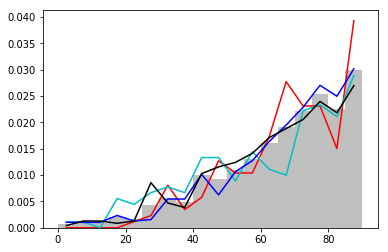

In [1134]:
# outflow channel stats

flat_outflow = [i for l in outflow_angles for i in l]

flat_outflowZ = [[i for n,l in enumerate(outflow_angles) for i in l if n in zone0_id],
[i for n,l in enumerate(outflow_angles) for i in l if n in zone1_id],
[i for n,l in enumerate(outflow_angles) for i in l if n in zone2_id],
[i for n,l in enumerate(outflow_angles) for i in l if n in zone3_id]]


dbin = 5
nbins = np.arange(0,90 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_outflowZ[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
    
plt.figure()
plt.hist(flat_outflow, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'c')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'k')

In [1110]:
flat_c_angles_all = [i for l in angle_differences for j in l for i in j]
flat_c_angles0 = [j[0] for l in angle_differences for j in l]
flat_c_angles1 = [j[1] for l in angle_differences for j in l]
flat_c_angles2 = [j[2] for l in angle_differences for j in l]

flat__c_anglesZ = [[i for n,l in enumerate(angle_differences) for i in l if n in zone0_id],
[i for n,l in enumerate(angle_differences) for i in l if n in zone1_id],
[i for n,l in enumerate(angle_differences) for i in l if n in zone2_id],
[i for n,l in enumerate(angle_differences) for i in l if n in zone3_id]]

flat_c_anglesZ = [[i for l in f for i in l] for f in flat__c_anglesZ]
flat_c_anglesZ0 = [[l[0] for l in f] for f in flat__c_anglesZ]
flat_c_anglesZ1 = [[l[1] for l in f] for f in flat__c_anglesZ]
flat_c_anglesZ2 = [[l[2] for l in f] for f in flat__c_anglesZ]

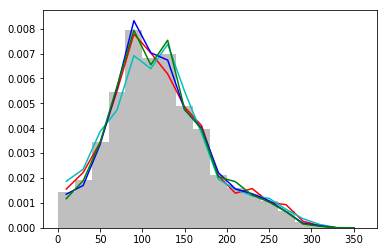

In [1135]:
dbin = 20
nbins = np.arange(0,360 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.figure()
plt.hist(flat_c_angles_all, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'c')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g')

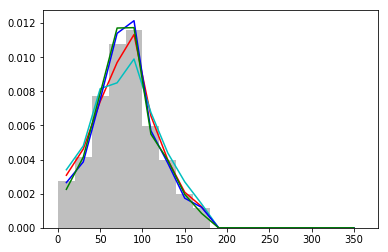

In [1136]:
dbin = 20
nbins = np.arange(0,360 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ0[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.figure()
plt.hist(flat_c_angles0, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'c')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g')

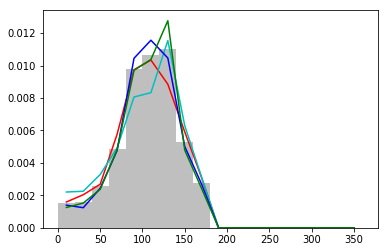

In [1137]:
dbin = 20
nbins = np.arange(0,360 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ1[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.figure()
plt.hist(flat_c_angles1, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'c')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g')

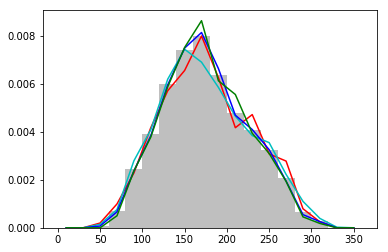

In [1138]:
dbin = 20
nbins = np.arange(0,360 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ2[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.figure()
plt.hist(flat_c_angles2, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'c')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g')

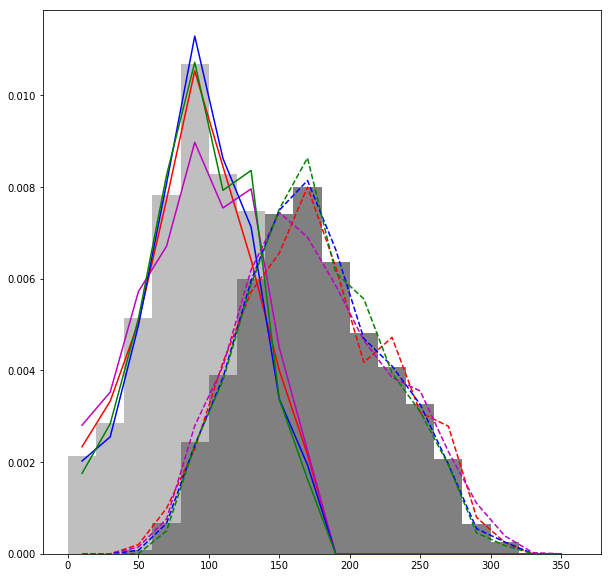

In [1139]:
# angles between incoming channel and channels bounding channel

dbin = 20
nbins = np.arange(0,360 + dbin,dbin)

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ0[i] + flat_c_anglesZ1[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.figure(figsize=(10,10))
plt.hist(flat_c_angles0 + flat_c_angles1, bins = nbins, normed = True, fc = '0.75')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'm')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g')


# angle between channels bounding island

q_vals = []

for i in range(4):
    vals, bins = np.histogram(flat_c_anglesZ2[i], bins = nbins, normed = True);
    q_vals.append(vals)

q_bins = bins
 
plt.hist(flat_c_angles2, bins = nbins, normed = True, fc = '0.5')
plt.plot(bins[:-1] + dbin/2., q_vals[0], 'r--')
plt.plot(bins[:-1] + dbin/2., q_vals[1], 'm--')
plt.plot(bins[:-1] + dbin/2., q_vals[2], 'b--')
plt.plot(bins[:-1] + dbin/2., q_vals[3], 'g--')

In [179]:
import pandas as pd

In [309]:
metrics = pd.DataFrame(fields, index = fields['id'].astype(int))
columns = metrics.columns
# new_columns = [c for c in columns if c not in ['area', 'id', 'label', 'p_label']]

new_columns = [
 'p_area',
    
 'avg_width',
 'ch_ang_med',
 'edge_dist',
 'out_numbr',
 'p_asp_rat',
 'p_circ',
 'p_concav',
 'p_convex',
 'p_d_shapef',
 'p_orient',
 'p_solidity',
 'p_w_shapef',
 'sin1000',
 'sin500']

new_columns = ['out_numbr', 'p_area']

metrics = pd.DataFrame(metrics[new_columns])

In [310]:
# pos = np.array([i.centroid.coords[0] for i in shp_islands2])

# xpos = pos[:,0]
# ypos = pos[:,1]

In [410]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
import time
import utm

In [393]:
kms_per_radian = 6371.0088

In [436]:
coords = np.array([utm.to_latlon(xpos[i], ypos[i], 45, zone_letter = 'N') for i in range(len(xpos))])

# define epsilon as 10 kilometers, converted to radians for use by haversine
epsilon = 15 / kms_per_radian

In [437]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))
print num_clusters

8


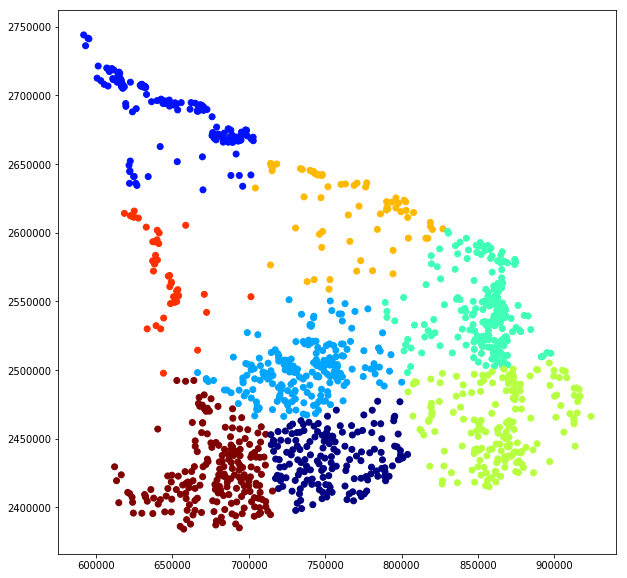

In [595]:
plt.figure(figsize=(10,10))

plt.scatter(xpos, ypos, c = results, cmap = 'jet')

In [499]:
# find neighbors for network of islands

from itertools import izip as zip, count # izip for maximum efficiency

neighs = []

for isl in range(len(flat_bounds)):
    r = [d for d in range(len(bounds)) if flat_bounds[isl] in bounds[d]]
    if len(r)>1:
        
        neighs.append(r)

In [1282]:
import networkx as nx
G = nx.Graph()

for n in range(len(bounds)):
    G.add_nodes_from([n], id = n)

G.add_edges_from(neighs)

G.remove_nodes_from(bad_islands)

for n, g in enumerate(list(G.nodes)):
    G.node[g]['position'] = pos[n]

node_alone = [n for n,j in G.degree() if j == 0]
G.remove_nodes_from(node_alone)

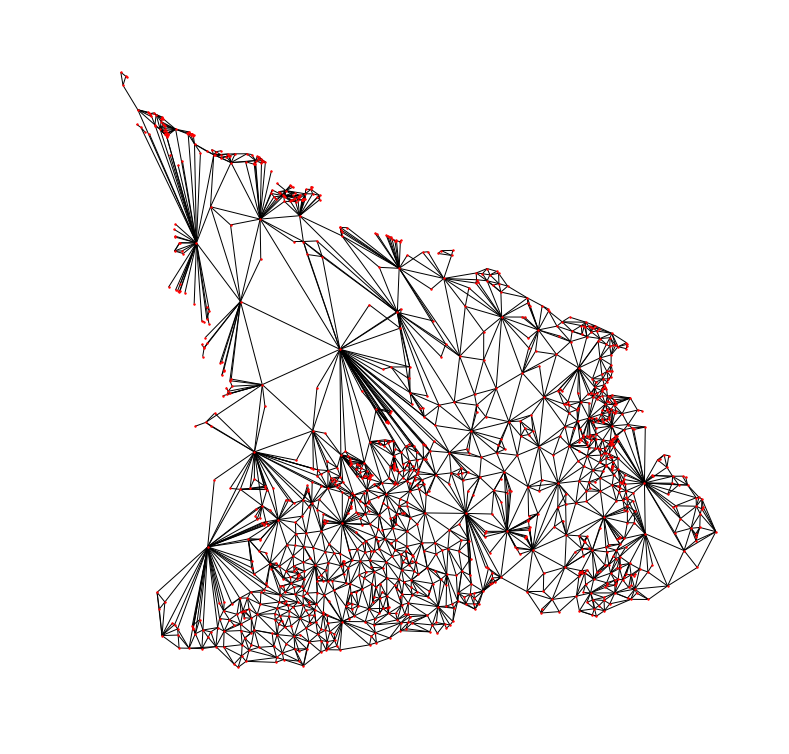

In [587]:
plt.figure(figsize=(10,10))
nx.draw(G, pos=G.nodes(data='position'), node_size=2)

In [1283]:
g = G.subgraph(range(0,60))

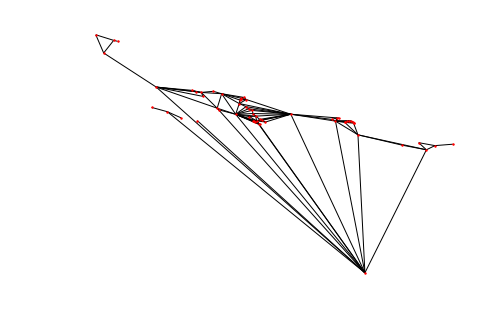

In [1255]:
nx.draw(g, pos=G.nodes(data='position'), node_size=2)

In [1257]:
path_length = dict(nx.all_pairs_shortest_path_length(g))
n = 60
distances = np.zeros((n,n))

for u,p in path_length.iteritems():
    for v,d in p.iteritems():
        distances[int(u)-1][int(v)-1] = d
        

In [1258]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

sd = distance.squareform(distances)

In [1259]:
hier = hierarchy.average(sd)

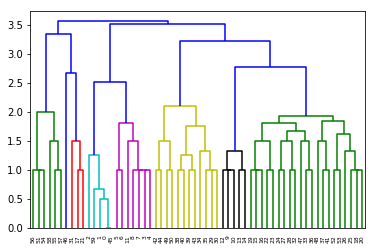

In [1262]:
import matplotlib
a = hierarchy.dendrogram(hier)
matplotlib.pylab.savefig("tree.png",format="png", dpi = 100)

In [1290]:
g.nodes[20]['color'] = 'g'

In [1274]:
colors = a['color_list'][np.array([int(i) for i in a['ivl']])]


TypeError: only integer scalar arrays can be converted to a scalar index

In [1276]:
[a['color_list'][j] for j in [int(i) for i in a['ivl']]]

IndexError: list index out of range

In [1277]:
j

59

In [1280]:
len(a['color_list'])

59

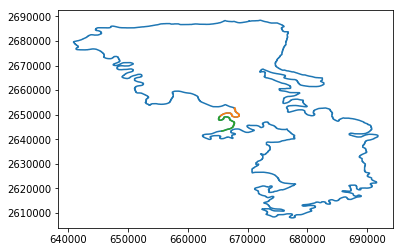

In [513]:
x,y = islands[90].boundary.xy
plt.plot(x,y)

x,y = lines[l1].xy
plt.plot(x,y)

x,y = lines[l2].xy
plt.plot(x,y)

In [165]:
# channels that touch each other

touching = []

for l1,l2 in itertools.combinations(range(len(lines)),2):
    
    if lines[l1].touches(lines[l2]):
        touching.append(linemerge([lines[l1],lines[l2]]))

In [166]:


touching2 = []

for l1,l2 in itertools.combinations(range(len(touching)),2):
    
    if touching[l1].touches(touching[l2]):
        touching2.append(linemerge([touching[l1],touching[l2]]))
        
len2 = len(touching2)



In [1427]:
# old

reload_islandmap = False

if reload_islandmap:

    src_ds = gdal.Open('ganges_metrics/island_map_HD.tif')

    try:
        srcband = src_ds.GetRasterBand(1)
    except RuntimeError, e:
        # for example, try GetRasterBand(10)
        print 'Band ( %i ) not found' % band_num
        print e
        sys.exit(1)

    raster = srcband.ReadAsArray()

    ulx, xres, xskew, uly, yskew, yres  = src_ds.GetGeoTransform()
    lrx = ulx + (src_ds.RasterXSize * xres)
    lry = uly + (src_ds.RasterYSize * yres)

    r_xmax, r_xmin, r_ymax, r_ymin = lrx, ulx, uly, lry
    pixel_size = xres

In [21]:
# old

save_islandmap = False
island_props_arrays = False
save_island_props_pickles = False

if save_islandmap:

    rasterOrigin = (r_xmin, r_ymin)
    pixelWidth = r_xres * 5
    pixelHeight = r_xres * 5
    newRasterfn = 'ganges_metrics/island_map_HD.tif'
    array = islandmap1

    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

    
if island_props_arrays:
    
    island_aspect_ratio = np.zeros(vel.shape)
    island_area = np.zeros(vel.shape)
    island_edge_dist = np.zeros(vel.shape)
    island_shape_factor = np.zeros(vel.shape)

    for n, v in enumerate(island_props['label']): 
        island_aspect_ratio[islandmap == v] = island_props['aspect_ratio'][n]
        island_area[islandmap == v] = island_props['area'][n]
        island_edge_dist[islandmap == v] = island_props['edge_dist'][n]
        island_shape_factor[islandmap == v] = island_props['shape_factor'][n]
        
        
if save_island_props_pickles:
    
    pickle.dump(island_aspect_ratio, open( 'ganges_metrics/island_aspect_ratio' + '.p', "wb" ) )
    pickle.dump(island_area, open( 'ganges_metrics/island_area' + '.p', "wb" ) )
    pickle.dump(island_edge_dist, open( 'ganges_metrics/island_edge_dist' + '.p', "wb" ) )
    pickle.dump(island_shape_factor, open( 'ganges_metrics/island_shape_factor' + '.p', "wb" ) )

In [192]:
get_polygons_from_islandmap = False

if get_polygons_from_islandmap:

    geoms = []

    for label in range(3,islandmap.max()):
        if np.sum((islandmap == label)) > 10:

            print label

            # image = gaussian_filter((islandmap == label) * 1., 1).astype('int16')
            image = (islandmap == label).astype('int16')
            geom = [{'properties': {'raster_val': v}, 'geometry': s}
                    for i, (s, v) in enumerate(shapes(image))]
            try:
                geoms.append(geom[-2])
            except:
                pass


    islands = []

    for i in range(len(geoms)):

        polygon = shape(geoms[i]['geometry'])
        polygon = transform(lambda x, y, z=None: (x*r_xres+r_xmin, r_ymax - y*r_xres), polygon)
        islands.append(polygon)

    pickle.dump(geoms, open( 'ganges_metrics/island_polygons' + '.p', "wb" ) )

In [1109]:
# c = fiona.open('ganges_metrics/nodes.shp')

# network_nodes = MultiPoint([shape(pol['geometry']) for pol in c])
# network_node_cat = [line['properties']['cat'] for line in c]


# node_nums = []
# dangle = []

# for l in network_lines:

#     c1 = Point(l.coords[0]).buffer(10)
#     c2 = Point(l.coords[-1]).buffer(10)

#     nearest_pt1 = [c1.intersects(pt) for pt in network_nodes]
#     nearest_pt2 = [c2.intersects(pt) for pt in network_nodes]
    
    
#     try:
#         node_num1 = np.where(np.array(nearest_pt1))[0][0]
#         cat1 = network_node_cat[node_num1]
#     except:
#         node_num1 = None
#         cat1 = None
    
#     try:
#         node_num2 = np.where(np.array(nearest_pt2))[0][0]
#         cat2 = network_node_cat[node_num2]
#     except:
#         node_num2 = None
#         cat2 = None
    
#     node_nums.append([node_num1, node_num2])
#     dangle.append([cat1, cat2])



# tribs = [n for n,i in enumerate(dangle) if max(i) == 1]


# for polygon in islands:

#     ch = polygon.convex_hull
#     near_channels = [n for n,l in enumerate(network_lines) if ch.intersects(l)]

#     for i in near_channels:

#         l = network_lines[i]

#         c1 = Point(l.coords[0]).buffer(10)
#         c2 = Point(l.coords[-1]).buffer(10)

#         inside = c1.intersects(polygon) or c2.intersects(polygon)
        
# #         inside = l.distance(polygon) < 10

#         if inside:
#             tribs.append(i)



# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]

# island_indices = np.zeros((len(not_tribs),2))
# distances = np.zeros((len(not_tribs),2))
# dists = np.zeros((len(islands),))

# for n,i in enumerate(not_tribs):

#     l = network_lines[i]
#     dists[:] = 0

#     for ni,p in enumerate(islands):
#         dists[ni] = l.distance(p)

#     x = np.argsort(dists)

#     distances[n,:] = [dists[x[0]], dists[x[1]]]
#     island_indices[n,:] = [x[0], x[1]]



# too_close = [i for n,i in enumerate(not_tribs) if min(distances[n]) < 10]
# tribs = np.unique(tribs + too_close)

# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]